In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import sys
from fxpmath import Fxp
import matplotlib.pyplot as plt

In [2]:
dir_current = os.path.abspath('')
dir_parent  = os.path.dirname(dir_current)
if not dir_parent in sys.path: sys.path.append(dir_parent)

In [3]:
from models import Weight_Quantization, Quantization_layer, Lenet_body
from functions import get_all_outputs, load_obj, save_obj

## Loading Dataset

In [23]:
# Loading Data
(_, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
del _
# Normalizando
x_test = x_test/255.
x_test  = tf.expand_dims(x_test, -1)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)

## Loading Quantized model

In [29]:
Frac_Bits = 5
Int_Bits  = 6

Qinput_layer  = tf.keras.Input((28,28,1))
Qoutput_layer = Lenet_body(Qinput_layer, Quantization = True, word_size = (Frac_Bits+Int_Bits+1), frac_size = Frac_Bits)
QLenet = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [30]:
# Loading Wieghts
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

QLenet.load_weights(Wgt_dir)

## Quantize Weights

In [31]:
Weight_Quantization(model = QLenet, Frac_Bits = 8, Int_Bits = 3)

## Experiment over Layers

In [32]:
Layers      = [(1,'Input'),(3,'Conv1'),(5,'Tanh1'),(6,'AP1'),(8,'Conv2'),(10,'Tanh2'),(11,'AP2'),(14,'Dense1'),
               (16,'Tanh3'),(18,'Dense2'),(20,'Tanh4'),(22,'Dense3'),(24,'SoftMax')]

batch  = 100
for idx in range(len(Layers)):
    activations= []
    iterator   = iter(test_dataset)
    image      = next(iterator)
    for im_index in range(batch):
        outputs   = get_all_outputs(QLenet, tf.expand_dims(image,axis=0))
        layer_out = outputs[Layers[idx][0]]
        activations.extend(Fxp(layer_out.flatten(),True,12,6).bin())
        image = next(iterator)
    Dict       = {11:0, 10:0, 9:0, 8:0, 7:0, 6:0, 5:0, 4:0, 3:0, 2:0, 1:0, 0:0}
    bit = 0
    while bit < 12:
        Dict[bit] = [item[bit] for item in activations].count("1")/len(activations)
        bit += 1
    save_obj(Dict,'Layers_Stats/Weed_Dataset/' + Layers[idx][1])
    print(Layers[idx][1],'Procesada')     

Input Procesada
Conv1 Procesada
Tanh1 Procesada
AP1 Procesada
Conv2 Procesada
Tanh2 Procesada
AP2 Procesada
Dense1 Procesada
Tanh3 Procesada
Dense2 Procesada
Tanh4 Procesada
Dense3 Procesada
SoftMax Procesada


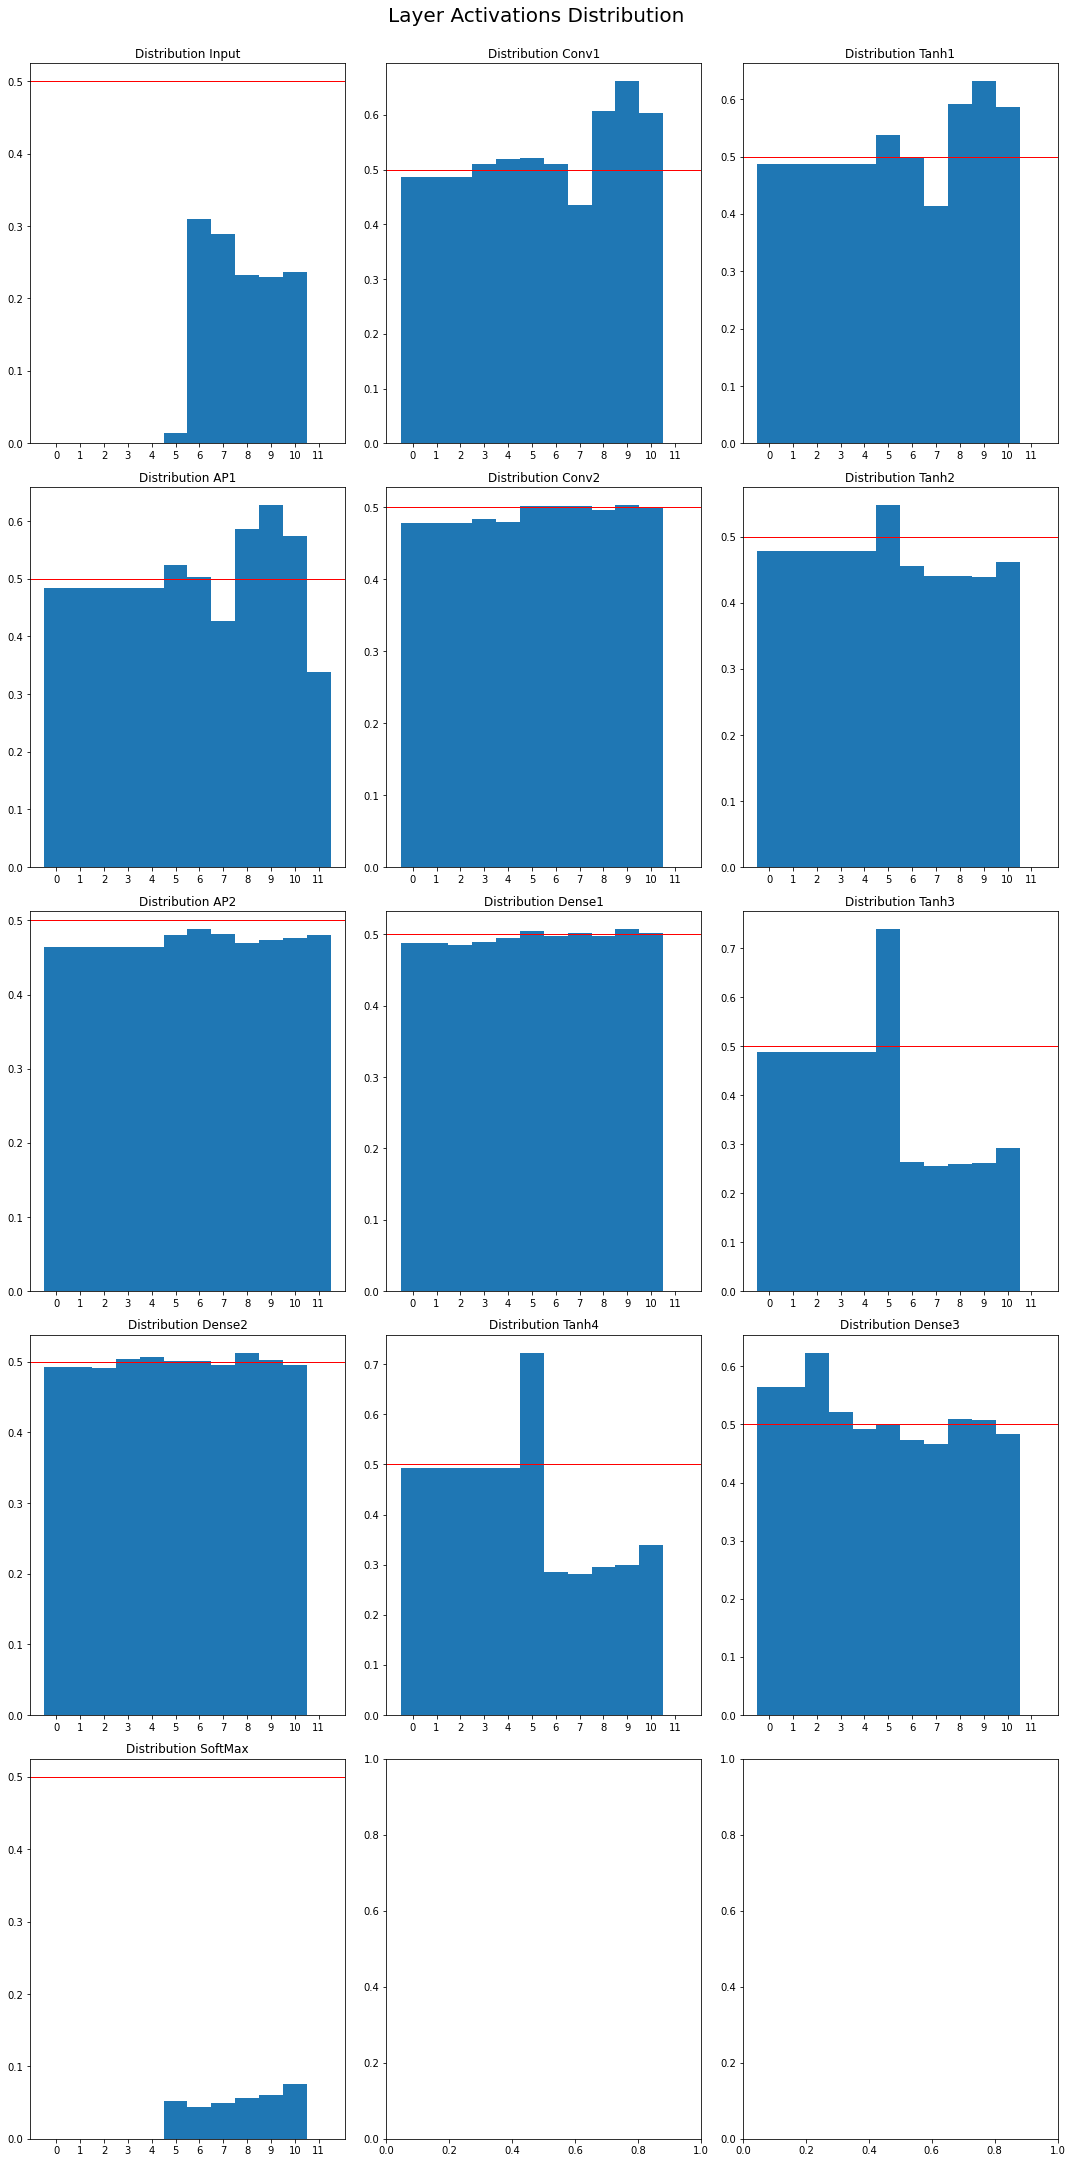

In [33]:
fig, axs = plt.subplots(5,3,figsize=(15,30))
fig.suptitle('Layer Activations Distribution',fontsize=20, y=1)
for row in range(5):
    for col in range(3):
        if 3*row + col < 13:
            Dict = load_obj('Layers_Stats/Weed_Dataset/' + Layers[row*3 + col][1])
            axs[row,col].bar(Dict.keys(), Dict.values(), 1)
            axs[row,col].set_title('Distribution ' + Layers[row*3 + col][1])
            axs[row,col].axhline(y=0.5,linewidth=1, color='r')
            axs[row,col].set_xticks(np.array(list(Dict.keys()),dtype=float))
            axs[row,col].set_xticklabels(Dict.keys())
plt.tight_layout()